In [2]:
#%%
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

C:\Users\Dennis\Anaconda3\envs\tensorflow_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Default GPU Device: /device:GPU:0


In [3]:
from __future__ import print_function, division

from keras.backend.tensorflow_backend import set_session  

config = tf.ConfigProto()  
config.gpu_options.allow_growth = True 
config.gpu_options.per_process_gpu_memory_fraction=0.7 
set_session(tf.Session(config=config)) 


Using TensorFlow backend.


In [4]:
import os
import sys
import glob
import argparse
import matplotlib.pyplot as plt
import numpy as np
from keras import __version__
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.preprocessing.image import img_to_array, array_to_img
from keras.models import load_model
from keras.models import save_model
from keras import regularizers

In [5]:


def get_nb_files(directory):
  """Get number of files by searching directory recursively"""
  if not os.path.exists(directory):
    return 0
  cnt = 0
  for r, dirs, files in os.walk(directory):
    for dr in dirs:
      cnt += len(glob.glob(os.path.join(r, dr + "/*")))
  return cnt

def plot_training(history):
  acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b-', label='training accuracy')
  plt.plot(epochs, val_acc, 'r-', label='validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.legend()
  

  plt.figure()
  plt.plot(epochs, loss, 'b-', label='training loss')
  plt.plot(epochs, val_loss, 'r-', label='validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()
    
    
    

In [28]:
"""Use transfer learning and fine-tuning to train a network on a new dataset"""

#setup datasets and variables

train_data_dir = 'D:\\Melanoma Class\\ISIC datasets\\train_dir'
test_data_dir = 'D:\\Melanoma Class\\ISIC datasets\\val_dir'


nb_train_samples = get_nb_files('D:\\Melanoma Class\\ISIC datasets\\train_dir')
nb_classes = len(glob.glob('D:\\Melanoma Class\\ISIC datasets\\train_dir' + "/*"))
nb_val_samples = get_nb_files('D:\\Melanoma Class\\ISIC datasets\\val_dir')
nb_epoch = 3
batch_size = 32
    
IM_WIDTH, IM_HEIGHT = 299, 299 #fixed size for InceptionV3
NB_EPOCHS = 3
BAT_SIZE = 32
FC_SIZE = 1024
NB_IV3_LAYERS_TO_FREEZE = 172
TL_LAYERS_FREEZE = 200


In [29]:
#initialize InceptionV3 model without top layer with ImageNet weights

base_model = InceptionV3(include_top=False, weights='imagenet', input_shape = (IM_WIDTH, IM_HEIGHT, 3)) 

In [30]:
#freeze layers

for layer in base_model.layers[:TL_LAYERS_FREEZE]:
    layer.trainable = False
for layer in base_model.layers[TL_LAYERS_FREEZE:]:
    layer.trainable = True   

In [31]:
#add top layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(FC_SIZE, activation='relu', kernel_regularizer=regularizers.l1(0.01))(x) #new FC layer, random init, add l1 regularization to classifier layer
predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer
model = Model(inputs=base_model.input, outputs=predictions)

In [32]:
#compile model
#use rmsprop optimizer

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['binary_accuracy', 'categorical_accuracy'])

In [33]:
len(base_model.layers)

311

In [34]:
len(model.layers)

314

In [35]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 149, 149, 32) 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 149, 149, 32) 0           batch_normalization_189[0][0]    
__________________________________________________________________________________________________
conv2d_190

In [39]:
#initialize test and training sets
#data augmentation with generator

train_datagen =  ImageDataGenerator(

    
    rescale = 1./255,
    fill_mode="nearest",
    
    rotation_range=359,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
  )

test_datagen = ImageDataGenerator(

    
    rescale=1./255,
    fill_mode="nearest",
    
    rotation_range=359,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
  )

train_generator = train_datagen.flow_from_directory(
    'D:\\Melanoma Class\\ISIC datasets\\train_dir',
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=batch_size,
    
  )

validation_generator = test_datagen.flow_from_directory(
    'D:\\Melanoma Class\\ISIC datasets\\val_dir',
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=batch_size,
    
  )

Found 10349 images belonging to 2 classes.
Found 1397 images belonging to 2 classes.


In [40]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, CSVLogger


#generate callbacks to control run

file_path = '180511_best_weights.h5'

#check best weights and overwrite during run
checkpoint = ModelCheckpoint(file_path, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1 )

#stop run early if no improvement
early = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')
#tboard = Tensorboard(log_dir='./logs', histogram_freq=5, batch_size=32, write_graph=False, write_grads=False, write_images=False)

#save training performance over epochs
csvlog = CSVLogger('180511_training.log')



In [42]:
history_tl = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples/batch_size,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=nb_val_samples/batch_size,
    class_weight='auto',
    callbacks = [checkpoint, early, csvlog]
)



Epoch 1/2
324/323 [==============================] - 3048s 9s/step - loss: 13.8535 - binary_accuracy: 0.8154 - categorical_accuracy: 0.8154 - val_loss: 12.3297 - val_binary_accuracy: 0.8597 - val_categorical_accuracy: 0.8597

Epoch 00001: val_categorical_accuracy improved from -inf to 0.85970, saving model to 180511_best_weights.h5
Epoch 2/2
324/323 [==============================] - 3145s 10s/step - loss: 10.8397 - binary_accuracy: 0.8427 - categorical_accuracy: 0.8427 - val_loss: 12.1750 - val_binary_accuracy: 0.8611 - val_categorical_accuracy: 0.8611

Epoch 00002: val_categorical_accuracy improved from 0.85970 to 0.86113, saving model to 180511_best_weights.h5


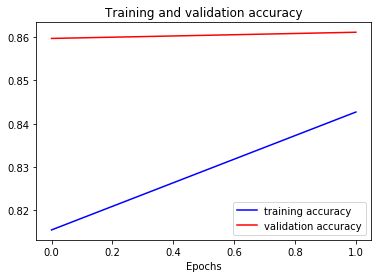

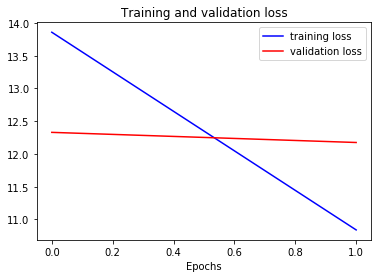

In [43]:
plot_training(history_tl)

In [44]:
import h5py

model.save('180511_tl.h5')


In [45]:
#set up to fine tune

for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
     layer.trainable = False
for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
     layer.trainable = True
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [46]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 149, 149, 32) 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 149, 149, 32) 0           batch_normalization_189[0][0]    
__________________________________________________________________________________________________
conv2d_190

In [47]:
file_path_ft = '180511_best_weights_ft.h5'

checkpoint_ft = ModelCheckpoint(file_path_ft, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1 )
early_ft = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.005, patience=4, verbose=1, mode='auto')
#tboard = Tensorboard(log_dir='./logs', histogram_freq=5, batch_size=32, write_graph=False, write_grads=False, write_images=False)
csvlog_ft = CSVLogger('180511_training_ft.log')

In [48]:
#fine tuning

history_ft = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples/batch_size,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=nb_val_samples/batch_size,
    class_weight='auto',
    callbacks = [checkpoint_ft, early_ft, csvlog_ft]
    )

Epoch 1/2
324/323 [==============================] - 3395s 10s/step - loss: 1.0037 - categorical_accuracy: 0.8640 - val_loss: 0.7136 - val_categorical_accuracy: 0.8604

Epoch 00001: val_categorical_accuracy improved from -inf to 0.86042, saving model to 180511_best_weights_ft.h5
Epoch 2/2
324/323 [==============================] - 3542s 11s/step - loss: 0.6046 - categorical_accuracy: 0.8675 - val_loss: 0.7269 - val_categorical_accuracy: 0.8604

Epoch 00002: val_categorical_accuracy did not improve


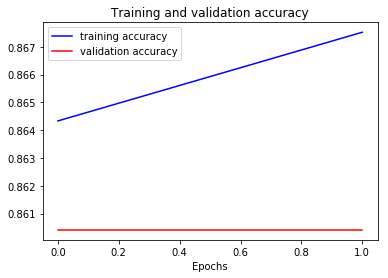

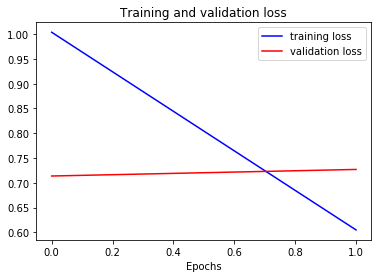

In [49]:
plot_training(history_ft)

In [50]:
model.save('180511_ft.h5')

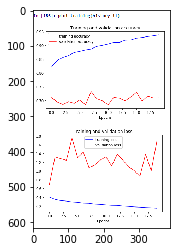

In [52]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


#show past training log with epochs=20


img = mpimg.imread('180505_tl_trainiglog.png')
plt.imshow(img)
plt.show()

In [53]:
#load own model

model1=load_model('180510_best_weights_ft.h5')

In [54]:
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [55]:
from PIL import Image
import requests
from io import BytesIO
from keras.preprocessing import image
import numpy as np
from keras.preprocessing import image
from IPython.display import display, Image
from PIL import Image

def predict(model, img, target_size):
  """Run model prediction on image
  Args:
    model: keras model
    img: PIL format image
    target_size: (w,h) tuple
  Returns:
    list of predicted labels and their probabilities
  """
  if img.size != target_size:
    img = img.resize(target_size)

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x/255
  #x = preprocess_input(x)
  preds = model.predict(x)
  return preds[0]



def plot_preds(image, preds):
  """Displays image and the top-n predicted probabilities in a bar graph
  Args:
    image: PIL image
    preds: list of predicted labels and their probabilities
  """
  plt.imshow(image)
  plt.axis('off')

  plt.figure()
  labels = ("benign", "malignant")
  plt.barh([0, 1], preds, alpha=0.5)
  plt.yticks([0, 1], labels)
  plt.xlabel('Probability')
  plt.xlim(0,1.01)
  plt.tight_layout()
  plt.show()

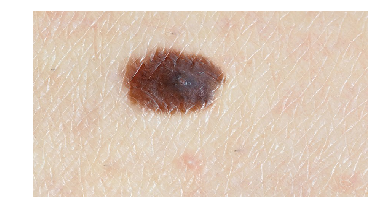

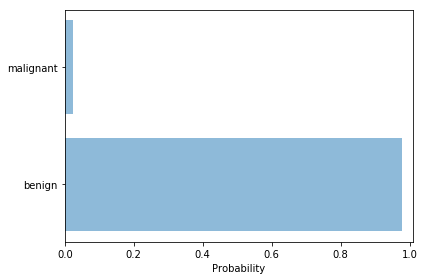

In [61]:
target_size= (299, 299)
response = requests.get('https://www.skyedermatology.com/media/custom/advancedslider/resized/slide-5781447e992a4-jpg/880X489.jpg')
img = Image.open(BytesIO(response.content))
preds = predict(model1, img, target_size)
plot_preds(img, preds)

In [110]:
test_data_dir = 'D:\\Melanoma Class\\ISIC datasets\\test_dir'
batch_size = 32
IM_WIDTH, IM_HEIGHT = 299, 299

test_datagen = ImageDataGenerator(
    #preprocessing_function=preprocess_input,
    rescale=1./255,

  )

validation_generator = test_datagen.flow_from_directory(
    'D:\\Melanoma Class\\ISIC datasets\\test_dir',
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=batch_size,
    shuffle=False,
    class_mode=None
  )  

Found 573 images belonging to 2 classes.


In [63]:
proba = model1.predict_generator(validation_generator, verbose=1)


18/18 [==============================] - 394s 22s/step


In [64]:
len(proba)

573

In [68]:
validation_generator.class_indices

{'benign': 0, 'malignant': 1}

In [111]:
#actual labels for test directory
y_test_val=validation_generator.classes
y_test_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [70]:
#predicted probabilities 

y_pred = proba[:,1]
y_pred

array([5.30590005e-02, 2.63917656e-03, 7.65836611e-03, 1.02234045e-02,
       2.53060804e-04, 8.30617137e-05, 2.02687904e-02, 1.62717514e-02,
       1.83655266e-02, 3.65940295e-03, 1.89166039e-03, 1.04243178e-02,
       5.09545067e-03, 3.26914638e-02, 1.13073595e-01, 8.77539441e-02,
       2.12096237e-02, 1.34630755e-01, 3.47684026e-01, 5.28684795e-01,
       6.10302389e-01, 2.45463178e-01, 6.53974339e-02, 1.15407193e-02,
       2.42943522e-02, 3.01757991e-01, 3.36746842e-01, 1.58894777e-01,
       3.02054584e-01, 1.37452543e-01, 1.18964547e-02, 1.43493727e-01,
       4.48916592e-02, 1.74080636e-02, 8.32143985e-03, 6.97220908e-03,
       7.47762769e-02, 8.90179947e-02, 2.61801362e-01, 7.71935983e-03,
       7.59775634e-04, 5.02304696e-02, 1.29317611e-01, 2.82800458e-02,
       3.42049781e-04, 2.29119033e-01, 2.44675856e-03, 5.23922732e-03,
       2.75590247e-03, 3.74218710e-02, 9.06989723e-03, 6.78506540e-03,
       1.82300247e-02, 1.61310844e-02, 4.89827432e-02, 4.28395309e-02,
      

In [74]:
y_pred_int = np.rint(proba[:,1])

In [71]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

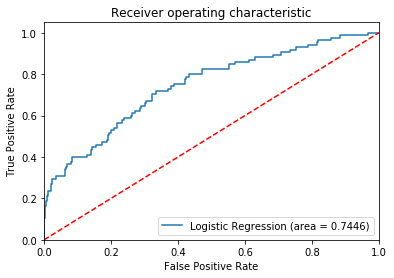

In [72]:
#generate AUC ROC

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [75]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_int)

array([[478,  10],
       [ 65,  20]], dtype=int64)

In [77]:
test_data_dir = 'D:\\Melanoma Class\\ISIC datasets\\train_dir'
batch_size = 32
IM_WIDTH, IM_HEIGHT = 299, 299

train_datagen = ImageDataGenerator(
    #preprocessing_function=preprocess_input,
    rescale=1./255,

  )

train_generator = train_datagen.flow_from_directory(
    'D:\\Melanoma Class\\ISIC datasets\\train_dir',
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=batch_size,
    shuffle=False,
    class_mode=None
  )  

Found 10349 images belonging to 2 classes.


In [78]:
probas = model1.predict_generator(validation_generator, verbose=1)

324/324 [==============================] - 2438s 8s/step


In [83]:
#actual labels for test directory
y_label=train_generator.classes
y_label

array([0, 0, 0, ..., 1, 1, 1])

In [99]:
#predicted probabilities 

y_prob = probas[:,1]
y_prob

array([0.09271505, 0.26566485, 0.05169283, ..., 0.00038526, 0.0092136 ,
       0.03453169], dtype=float32)

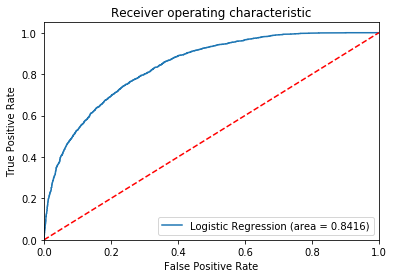

In [87]:
fpr, tpr, thresholds = roc_curve(y_label, y_prob)
roc_auc = auc(fpr, tpr)

#generate AUC ROC

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [100]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score

y_prob = y_prob.reshape(-1,1)


X_train, X_test, y_train, y_test = train_test_split(y_prob, y_label, test_size=0.2)

clf=DecisionTreeClassifier(max_depth=1)





In [101]:
cross_val_score(clf, y_prob, y_label, cv=5)

array([0.70241546, 0.81497585, 0.8468599 , 0.86280193, 0.85065249])

In [102]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [107]:
y_pred=y_pred.reshape(-1,1)
preds = clf.predict(y_pred)

In [112]:
confusion_matrix(preds, y_test_val)

array([[404,  45],
       [ 84,  40]], dtype=int64)